<img src='src/walmart-logo.jpg'>

# Walmart : predict weekly sales

## Company's Description 📇

Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville, Arkansas. The company was founded by Sam Walton in 1962.

## Project 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, accuracy_score
from geopy.geocoders import Nominatim

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"

## Loading dataset

In [2]:
w_sales = pd.read_csv('src/Walmart_Store_sales.csv')

In [3]:
w_sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


## Datas Overview

In [4]:
w_sales.info

<bound method DataFrame.info of      Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      6.0  18-02-2011    1572117.54           NaN        59.61       3.045   
1     13.0  25-03-2011    1807545.43           0.0        42.38       3.435   
2     17.0  27-07-2012           NaN           0.0          NaN         NaN   
3     11.0         NaN    1244390.03           0.0        84.57         NaN   
4      6.0  28-05-2010    1644470.66           0.0        78.89       2.759   
..     ...         ...           ...           ...          ...         ...   
145   14.0  18-06-2010    2248645.59           0.0        72.62       2.780   
146    7.0         NaN     716388.81           NaN        20.74       2.778   
147   17.0  11-06-2010     845252.21           0.0        57.14       2.841   
148    8.0  12-08-2011     856796.10           0.0        86.05       3.638   
149   19.0  20-04-2012    1255087.26           0.0        55.20       4.170   

            CPI  Un

### Changing Date in Timestamp format

In [5]:
type(w_sales['Date'][0])

str

In [6]:
def todatetime(mot):
    if type(mot) == str:
        return datetime.strptime(mot, '%d-%m-%Y')
w_sales['Date'] = w_sales['Date'].apply(todatetime)

In [7]:
# Dataset overview
w_sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,2012-07-27,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaT,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092


### Overview of features info

In [8]:
#Basic stats on data
w_sales.describe(include='all',datetime_is_numeric=True)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
mean,9.866667,2011-05-07 09:05:27.272727296,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,2010-08-16 12:00:00,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,2011-05-09 12:00:00,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,2012-01-14 18:00:00,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173


In [9]:
w_sales.isnull().sum()

Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

### Visualisation of the relations between each feature and the target

In [10]:
w_sales['Holiday_Flag'].values

array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1., nan,  1.,  0.,  0.,  0., nan,  0.,  0.,  0.,
        0., nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       nan,  0.,  0.,  0.,  0.,  0.,  1.,  0., nan,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0., nan,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0., nan,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1., nan,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., nan,  0.,  0.,  0.])

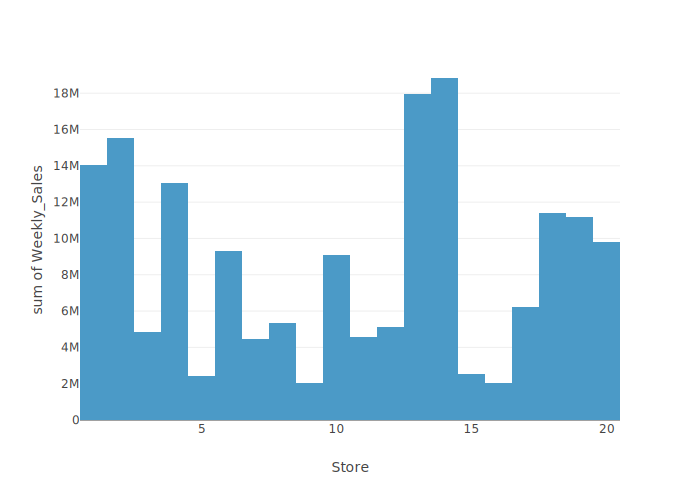

In [11]:
#Weekly sales over Store ID
s_store = px.histogram(w_sales, x='Store', y='Weekly_Sales', nbins=21)
s_store.show()

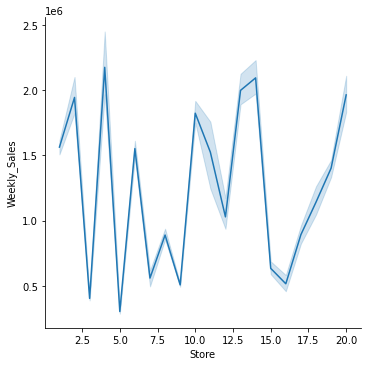

In [12]:
sns.relplot(
    data=w_sales, x="Store", y="Weekly_Sales",
    kind="line",
)

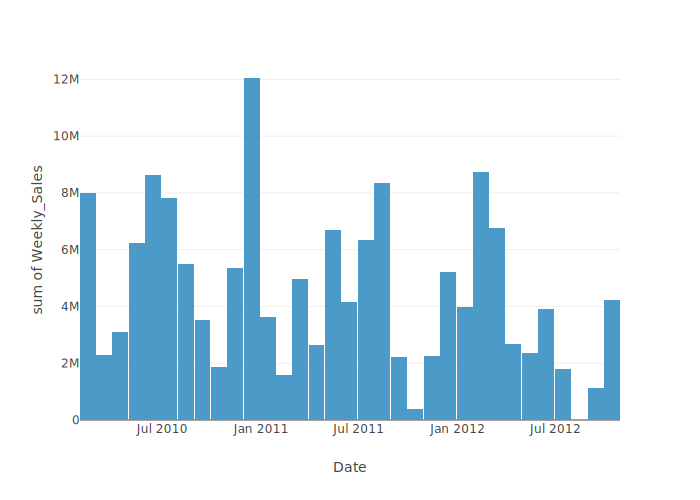

In [13]:
# Weekly sales over Date
s_date = px.histogram(w_sales, x='Date', y='Weekly_Sales', nbins=50)
s_date.show()

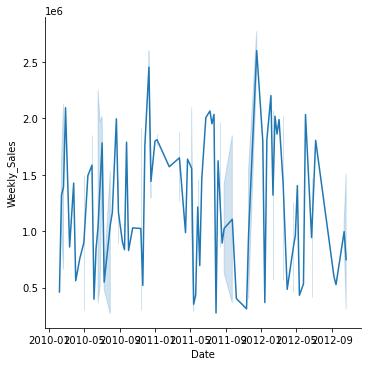

In [14]:
sns.relplot(
    data=w_sales, x="Date", y="Weekly_Sales",
    kind="line",
)

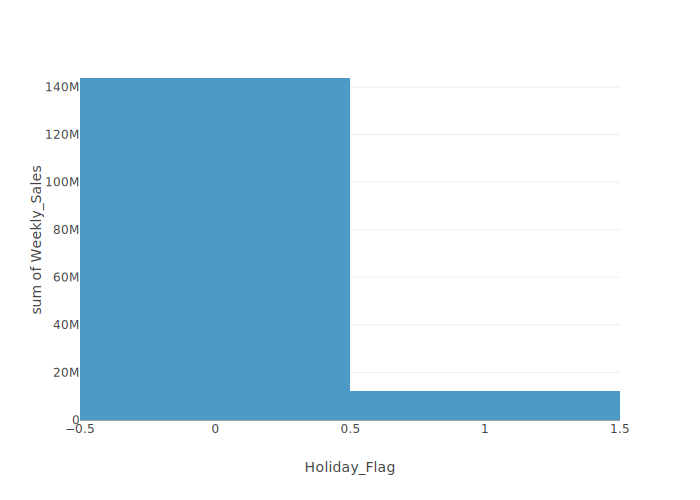

In [15]:
#Weekly sales over Holiday Flag
s_holy = px.histogram(w_sales, x='Holiday_Flag', y='Weekly_Sales', nbins=2)
s_holy.show()

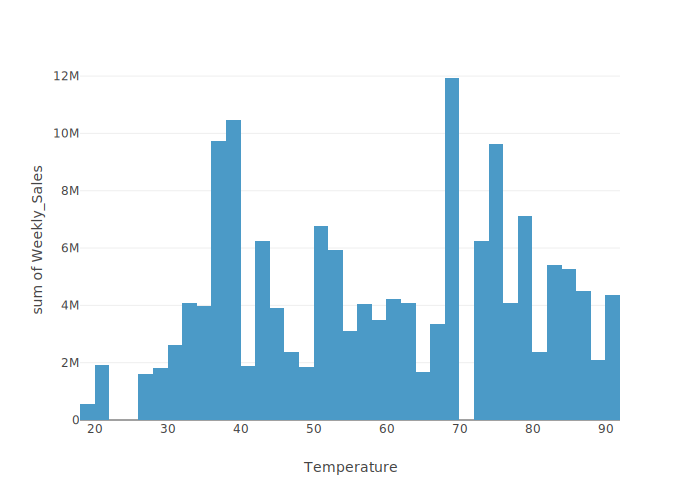

In [16]:
#Weekly sales over Temperature
s_temp = px.histogram(w_sales, x='Temperature', y='Weekly_Sales', nbins=37)
s_temp.show()

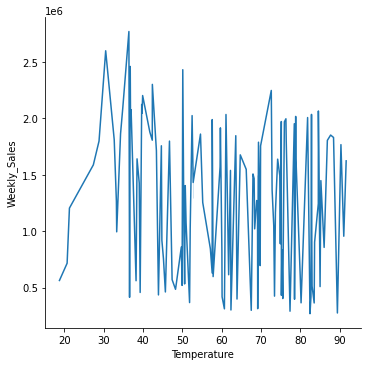

In [17]:
sns.relplot(
    data=w_sales, x="Temperature", y="Weekly_Sales",
    kind="line",
)

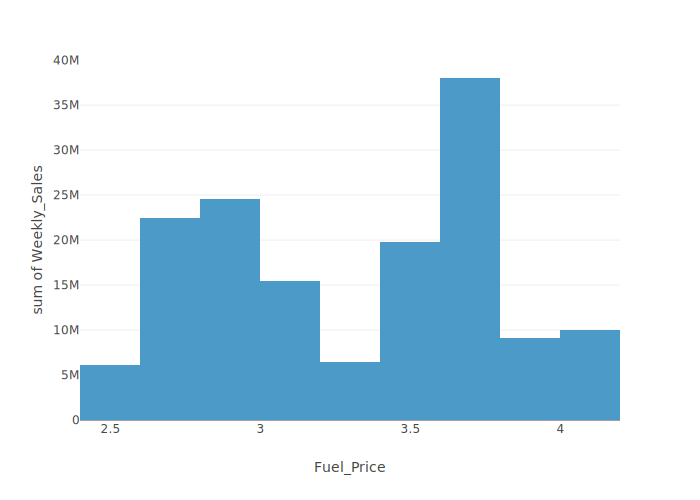

In [18]:
#Weekly sales over Fuel price
s_fuel = px.histogram(w_sales, x='Fuel_Price', y='Weekly_Sales')
s_fuel.show()

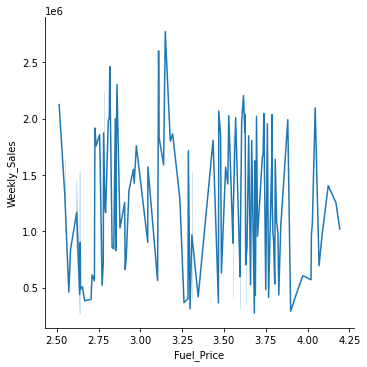

In [19]:
sns.relplot(
    data=w_sales, x="Fuel_Price", y="Weekly_Sales",
    kind="line",
)

In [20]:
w_sales.corr().values.round(2)

array([[ 1.  ,  0.12, -0.03, -0.26,  0.18, -0.59,  0.22],
       [ 0.12,  1.  ,  0.04, -0.17, -0.02, -0.29,  0.06],
       [-0.03,  0.04,  1.  , -0.19, -0.12,  0.17,  0.1 ],
       [-0.26, -0.17, -0.19,  1.  ,  0.05,  0.14, -0.03],
       [ 0.18, -0.02, -0.12,  0.05,  1.  , -0.16,  0.09],
       [-0.59, -0.29,  0.17,  0.14, -0.16,  1.  , -0.35],
       [ 0.22,  0.06,  0.1 , -0.03,  0.09, -0.35,  1.  ]])

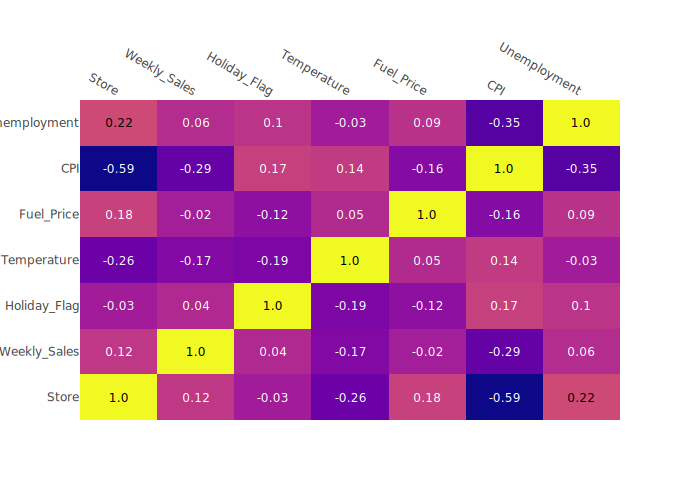

In [21]:
#Matrix of correlations between the columns
fig = ff.create_annotated_heatmap(w_sales.corr().values.round(2),
                                  x = w_sales.corr().columns.values.tolist(),
                                  y = w_sales.corr().index.values.tolist())


fig.show()

## Preprocessing

### Dropping lines with missing target values

Here, there are no obviuous column to drop so we will focus on dropping useless lines

In [22]:
to_keep = ~(w_sales['Weekly_Sales'].isna())
w_sales = w_sales.loc[to_keep,:]
w_sales.isnull().sum()

Store            0
Date            18
Weekly_Sales     0
Holiday_Flag    11
Temperature     15
Fuel_Price      12
CPI             11
Unemployment    14
dtype: int64

In [23]:
w_sales.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,136.000000,1.360000e+02,125.000000,121.000000,124.000000,125.000000,122.000000
mean,10.014706,1.249536e+06,0.072000,60.853967,3.316992,178.091144,7.665582
std,6.124614,6.474630e+05,0.259528,18.514432,0.479540,40.243105,1.619428
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.220000,2.838500,131.637000,6.690000
50%,10.000000,1.261424e+06,0.000000,62.250000,3.451000,196.919506,7.477000
75%,15.250000,1.806386e+06,0.000000,75.950000,3.724000,214.878556,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000


### Creating usable features from Date

In [24]:
w_sales['Date'][4].day

28

In [25]:
#Creating a column with the year
w_sales['year'] = w_sales['Date'].apply(lambda x : x.year)

In [26]:
#Creating a column with the month
w_sales['month'] = w_sales['Date'].apply(lambda x : x.month)

In [27]:
#Creating a column with the day of the month
w_sales['day_of_month'] = w_sales['Date'].apply(lambda x : x.day)

In [28]:
#Looking wich days of the week are represented
w_sales['Date'].apply(lambda x : x.day_of_week)

0      4.0
1      4.0
3      NaN
4      4.0
5      4.0
      ... 
145    4.0
146    NaN
147    4.0
148    4.0
149    4.0
Name: Date, Length: 136, dtype: float64

In [29]:
w_sales['Date'].apply(lambda x : x.day_of_week).value_counts()

4.0    118
Name: Date, dtype: int64

Here, the day of the week has only one value wich is 4. Since it means that it's alway friday, we won't need to add this column as it does not provide any useful information

Now we can drop the date column

In [30]:
w_sales = w_sales.drop(['Date'], axis=1)

In [31]:
w_sales.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day_of_month
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010.0,5.0,28.0


### Dropping outliers in Temperature, Fuel_price, CPI and Unemployment

In [32]:
# Setting conditions for Temperatures lines to keep
temp_to_keep = (
                (w_sales['Temperature'] > (w_sales['Temperature'].mean() - (3*w_sales['Temperature'].std()))) 
                & 
                (w_sales['Temperature'] < (w_sales['Temperature'].mean() + (3*w_sales['Temperature'].std())))
)


In [33]:
# Setting conditions for Fuel price lines to keep
fc_to_keep = (
                (w_sales['Fuel_Price'] > (w_sales['Fuel_Price'].mean() - (3*w_sales['Fuel_Price'].std()))) 
                & 
                (w_sales['Fuel_Price'] < (w_sales['Fuel_Price'].mean() + (3*w_sales['Fuel_Price'].std())))
)

In [34]:
# Setting conditions for CPI lines to keep
cpi_to_keep = (
                (w_sales['CPI'] > (w_sales['CPI'].mean() - (3*w_sales['CPI'].std()))) 
                & 
                (w_sales['CPI'] < (w_sales['CPI'].mean() + (3*w_sales['CPI'].std())))
)

In [35]:
# Setting conditions for Unemployment lines to keep
unemp_to_keep = (
                (w_sales['Unemployment'] > (w_sales['Unemployment'].mean() - (3*w_sales['Unemployment'].std()))) 
                & 
                (w_sales['Unemployment'] < (w_sales['Unemployment'].mean() + (3*w_sales['Unemployment'].std())))
)

In [36]:
w_sales['Unemployment'][85]

8.027999999999999

In [37]:
# Dropping the corresponding lines
w_sales = w_sales.loc[temp_to_keep,:]
w_sales = w_sales.loc[fc_to_keep,:]
w_sales = w_sales.loc[cpi_to_keep,:]
w_sales = w_sales.loc[unemp_to_keep,:]
w_sales

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day_of_month
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0
6,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011.0,6.0,3.0
7,20.0,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...
139,7.0,532739.77,0.0,50.60,3.804,197.588605,8.090,2012.0,5.0,25.0
143,3.0,396968.80,0.0,78.53,2.705,214.495838,7.343,2010.0,6.0,4.0
144,3.0,424513.08,0.0,73.44,3.594,226.968844,6.034,2012.0,10.0,19.0
145,14.0,2248645.59,0.0,72.62,2.780,182.442420,8.899,2010.0,6.0,18.0


### Seperate features from target

#### Getting Features and target labels and seperate data

In [38]:
X_labels = w_sales.columns.tolist()
Y_label = X_labels.pop(X_labels.index('Weekly_Sales'))
X = w_sales[X_labels]
Y = w_sales[Y_label]

In [39]:
X.head()

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day_of_month
0,6.0,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0
1,13.0,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0
4,6.0,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0
6,15.0,0.0,69.80,4.069,134.855161,7.658,2011.0,6.0,3.0
7,20.0,0.0,39.93,3.617,213.023622,6.961,2012.0,2.0,3.0


In [40]:
Y.head()

0    1572117.54
1    1807545.43
4    1644470.66
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64

### Identifying categorical and numerical variables in features

In [41]:
numerical_labels = X_labels
categorical_labels = [numerical_labels.pop(numerical_labels.index('Store'))]
categorical_labels.append(numerical_labels.pop(numerical_labels.index('Holiday_Flag')))

In [42]:
numerical_labels

['Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'year',
 'month',
 'day_of_month']

In [43]:
categorical_labels

['Store', 'Holiday_Flag']

### Splitting training and testing sets

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

### Pipelines for caterorical and numerical features

In [45]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_labels),
        ('cat', cat_transformer, categorical_labels)
    ])

In [46]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [47]:
X_train

array([[ 0.70516394, -1.13980519,  0.62142729, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.91740363, -1.12721323, -1.39889017, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71388612, -1.61410219,  0.88703934, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.38059979,  1.22748251,  0.44510476, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.83367071,  1.14983212,  0.92969294, ...,  0.        ,
         0.        ,  0.        ],
       [-0.04610641, -0.09047553,  0.97312818, ...,  0.        ,
         0.        ,  0.        ]])

## Create and train linear regression model

In [48]:
# training the model
l_reg = LinearRegression()
l_reg.fit(X_train, Y_train)
Y_train_pred = l_reg.predict(X_train)
Y_test_pred = l_reg.predict(X_test)

### Score

In [49]:
print('R2 score on train set : ', r2_score(Y_train, Y_train_pred))
print('R2 score on test set : ', r2_score(Y_test, Y_test_pred))

R2 score on train set :  0.981744227361412
R2 score on test set :  0.9470437168592518


In [50]:
# Retriving Labels from encoded column into a list
one_hot_encoded_labels = preprocessor.transformers_[1][1][1].get_feature_names_out(categorical_labels).tolist()

In [51]:
feature_labels = one_hot_encoded_labels + numerical_labels
feature_labels

['Store_2.0',
 'Store_3.0',
 'Store_4.0',
 'Store_5.0',
 'Store_6.0',
 'Store_7.0',
 'Store_8.0',
 'Store_9.0',
 'Store_10.0',
 'Store_11.0',
 'Store_13.0',
 'Store_14.0',
 'Store_15.0',
 'Store_16.0',
 'Store_17.0',
 'Store_18.0',
 'Store_19.0',
 'Store_20.0',
 'Holiday_Flag_1.0',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'year',
 'month',
 'day_of_month']

In [52]:
# Getting the models coefficients in absolute values a dictionary
coeff = dict([(f, abs(round(c, 2))) for f,c in zip(feature_labels, l_reg.coef_.tolist())])

# Sorting coefficients by values
coeff = {k: v for k, v in sorted(coeff.items(), key=lambda item: item[1])}
coeff

{'Store_5.0': 12029.21,
 'Store_7.0': 26998.99,
 'Store_6.0': 30115.01,
 'Store_2.0': 37959.54,
 'Store_8.0': 43671.69,
 'Store_3.0': 64201.87,
 'day_of_month': 82925.35,
 'Store_14.0': 108927.46,
 'Store_19.0': 167148.62,
 'Store_9.0': 340122.53,
 'month': 528621.42,
 'Store_15.0': 569382.34,
 'Fuel_Price': 573469.68,
 'Store_16.0': 739224.58,
 'Store_4.0': 820605.12,
 'Temperature': 847406.93,
 'CPI': 952683.05,
 'Holiday_Flag_1.0': 1158964.78,
 'Store_17.0': 1191552.13,
 'Unemployment': 1206137.81,
 'Store_10.0': 1279584.69,
 'Store_13.0': 1280089.65,
 'year': 1560971.82,
 'Store_18.0': 2200542.84,
 'Store_20.0': 2258469.55,
 'Store_11.0': 2513882.75}

    * Here, the r2 score on the train set is very close to 1, so we can suspect an overfit
    * 3 of the stores have the highest coefficient. Therefore, they are the most important for the predictions on this model

## Regularized Models

### Ridge Model

In [53]:
ridge_m = Ridge()
ridge_m.fit(X_train, Y_train)
ridge_m_train_pred = ridge_m.predict(X_train)
ridge_m_test_pred = ridge_m.predict(X_test)

In [54]:
#R2 score of the ridge model on train set
ridge_m.score(X_train, Y_train)

0.9260810166547855

In [55]:
#R2 score of the ridge model on test set
ridge_m.score(X_test, Y_test)

0.8750851164766239

    * There is less overfitting

### Lasso model

In [56]:
lasso_m = Lasso(max_iter=1000000000)
lasso_m.fit(X_train, Y_train)
lasso_m_train_pred = lasso_m.predict(X_train)
lasso_m_test_pred = lasso_m.predict(X_test)

In [57]:
#R2 score of the lasso model on train set
lasso_m.score(X_train, Y_train)

0.981743419757902

In [58]:
#R2 score of the ridge model on test set
lasso_m.score(X_test, Y_test)

0.9474750340756298

    * We are still overtting 

### Grid search

In [59]:
# Grid search for alpha with Ridge
params_r = {'alpha': np.arange(0,1000,1)} 
ridge_gs = Ridge()

grid_r = GridSearchCV(ridge_gs, params_r, cv = 10, verbose = 1)
grid_r_fit = grid_r.fit(X_train, Y_train)
print("Optimal value for alpha : ", grid_r_fit.best_params_)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Optimal value for alpha :  {'alpha': 0}


In [60]:
scores_r = cross_val_score(grid_r_fit.best_estimator_, X_train, Y_train, cv = 10)

print('The cross-validated R2-score is : ', scores_r.mean())
print('The standard deviation is : ', scores_r.std())

The cross-validated R2-score is :  0.8859773752658043
The standard deviation is :  0.18806376921680554


In [61]:
# Grid search for alpha with Lasso
params_l = {'alpha' : [10**(-a) for a in range(10)]}
lasso_gs = Lasso(max_iter=1000000000)

grid_l = GridSearchCV(lasso_gs, params_l, cv = 10, verbose = 1)
grid_l_fit = grid_l.fit(X_train, Y_train)
print("Optimal value for alpha : ", grid_l_fit.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Optimal value for alpha :  {'alpha': 1}


In [62]:
scores_l = cross_val_score(grid_l_fit.best_estimator_, X_train, Y_train, cv = 10)

print('The cross-validated R2-score is : ', scores_l.mean())
print('The standard deviation is : ', scores_l.std())

The cross-validated R2-score is :  0.8891046481641054
The standard deviation is :  0.17853986023433843
